## Imports

In [1]:
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]='true'
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

import tensorflow as tf

from tf_agents                       import specs
from tf_agents.networks              import actor_distribution_network
from quantum_control_rl_server       import PPO
from quantum_control_rl_server       import remote_env_tools as rmt
from quantum_control_rl_server.h5log import h5log

In [2]:
root_dir = os.getcwd() 
host_ip  = '127.0.0.1' # ip address of RL server, here it's hosted locally

In [3]:
num_epochs       = 100 # total number of training epochs
train_batch_size = 50 # number of batches to send for training epoch

do_evaluation    = True # flag for implementing eval epochs or not
eval_interval    = 20 # number of training epochs between eval epochs
eval_batch_size  = 1 # number of batches to send for eval epoch

learn_residuals  = True
save_tf_style    = False

In [4]:

# Params for action wrapper
action_script = {
  'amp' : [[0.5]], # shape=[1,1]
  'drag' : [[0.0]], # shape=[1,1]
  'detuning' : [[0.0]]
  }

# specify shapes of actions to be consistent with the objects in action_script
action_spec = {
  'amp'      : specs.TensorSpec(shape=[1], dtype=tf.float32),
  'drag'     : specs.TensorSpec(shape=[1], dtype=tf.float32),
  'detuning' : specs.TensorSpec(shape=[1], dtype=tf.float32)
  }

# characteristic scale of sigmoid functions used in the neural network, 
# and for automatic differentiation of the reward
# optimal point should ideally be within +/- action_scale of the initial vals
action_scale = {
  'amp'      : 0.3,
  'drag'     : 0.5,
  'detuning' : 0.02 # freq in GHz for the sim
  }

# flags indicating whether actions will be learned or scripted
to_learn = {
  'amp'      : True,
  'drag'     : True,
  'detuning' : True
  }

rl_params = {'num_epochs'       : num_epochs,
             'train_batch_size' : train_batch_size,
             'do_evaluation'    : do_evaluation,
             'eval_interval'    : eval_interval,
             'eval_batch_size'  : eval_batch_size,
             'learn_residuals'  : learn_residuals,
             'action_script'    : action_script,
             #'action_spec' : action_spec, # doesn't play nice with h5 files
             'action_scale'     : action_scale,
             'to_learn'         : to_learn,
             'save_tf_style'    : save_tf_style}

log = h5log(root_dir, rl_params)

\\storage.yale.edu\home\qulab-cc1558-fasapp\users\akshay_koottandavida\code\quantum_control_rl_server\quantum_control_rl_server\h5log.py:31: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(self.filename)


In [5]:

############################################################
# Below code shouldn't require modification for normal use #
############################################################

# Create drivers for data collection
from quantum_control_rl_server import dynamic_episode_driver_sim_env

server_socket = rmt.Server()
(host, port) = (host_ip, 5555) 
server_socket.bind((host, port))
server_socket.connect_client()

# Params for environment
env_kwargs = eval_env_kwargs = {
  'T' : 1}

# Params for reward function
reward_kwargs = {
    'reward_mode'   : 'remote',
    'server_socket' : server_socket,
    'epoch_type'    : 'training'}

reward_kwargs_eval = {
    'reward_mode'   : 'remote',
    'server_socket' : server_socket,
    'epoch_type'    : 'evaluation'}

collect_driver = dynamic_episode_driver_sim_env.DynamicEpisodeDriverSimEnv(
    env_kwargs, reward_kwargs, train_batch_size, action_script, action_scale,
    action_spec, to_learn, learn_residuals, remote=True)

eval_driver = dynamic_episode_driver_sim_env.DynamicEpisodeDriverSimEnv(
    eval_env_kwargs, reward_kwargs_eval, eval_batch_size, action_script, action_scale,
    action_spec, to_learn, learn_residuals, remote=True)

PPO.train_eval(
    root_dir    = root_dir,
    random_seed = 0,
    num_epochs  = num_epochs,
    # Params for train
    normalize_observations    = True,
    normalize_rewards         = False,
    discount_factor           = 1.0,
    lr                        = 2.5e-3,
    lr_schedule               = None,
    num_policy_updates        = 20,
    initial_adaptive_kl_beta  = 0.0,
    kl_cutoff_factor          = 0,
    importance_ratio_clipping = 0.1,
    value_pred_loss_coef      = 0.005,
    gradient_clipping         = 1.0,
    entropy_regularization    = 0,
    log_prob_clipping         = 0.0,
    # Params for log, eval, save
    eval_interval       = eval_interval,
    save_interval       = 2,
    checkpoint_interval = None,
    summary_interval    = 2,
    do_evaluation       = do_evaluation,
    # Params for data collection
    train_batch_size       = train_batch_size,
    eval_batch_size        = eval_batch_size,
    collect_driver         = collect_driver,
    eval_driver            = eval_driver,
    replay_buffer_capacity = 15000,
    # Policy and value networks
    ActorNet                      = actor_distribution_network.ActorDistributionNetwork,
    zero_means_kernel_initializer = False,
    init_action_stddev = 0.08,
    actor_fc_layers    = (50,20),
    value_fc_layers    = (),
    use_rnn            = False,
    actor_lstm_size    = (12,),
    value_lstm_size    = (12,),
    h5datalog          = log,
    save_tf_style      = save_tf_style
    )


05/17/2023 05:51:51 Connection with: ('127.0.0.1', 64087)
05/17/2023 05:51:51 Only tf.keras.optimizers.Optimiers are well supported, got a non-TF2 optimizer: <tensorflow.python.training.adam.AdamOptimizer object at 0x000001D2B1152550>
\\storage.yale.edu\home\qulab-cc1558-fasapp\users\akshay_koottandavida\code\quantum_control_rl_server\quantum_control_rl_server\h5log.py:70: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(self.filename)


-------------------
Epoch 0
  Policy steps: 0
  Experience time: 0.00 mins
  Policy train time: 0.00 mins
  Average return: -0.26961
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=True)` instead.


05/17/2023 05:51:52 From \\storage.yale.edu\home\qulab-cc1558-fasapp\users\akshay_koottandavida\code\quantum_control_rl_server\quantum_control_rl_server\PPO.py:230: ReplayBuffer.gather_all (from tf_agents.replay_buffers.replay_buffer) is deprecated and will be removed in a future version.
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=True)` instead.


-------------------
Epoch 20
  Policy steps: 400
  Experience time: 0.24 mins
  Policy train time: 0.35 mins
  Average return: 0.96569
-------------------
Epoch 40
  Policy steps: 800
  Experience time: 0.45 mins
  Policy train time: 0.37 mins
  Average return: 0.99037
-------------------
Epoch 60
  Policy steps: 1200
  Experience time: 0.67 mins
  Policy train time: 0.39 mins
  Average return: 0.99037
-------------------
Epoch 80
  Policy steps: 1600
  Experience time: 0.89 mins
  Policy train time: 0.42 mins
  Average return: 0.99035
-------------------
Epoch 100
  Policy steps: 2000
  Experience time: 1.11 mins
  Policy train time: 0.44 mins
  Average return: 0.99040


In [8]:
import h5py
import numpy             as np
import matplotlib.pyplot as plt


# Get the results of training 
root_dir = os.getcwd()
filename = root_dir+r'\20230517.h5'
key      = '18'
with h5py.File(filename,'r') as f :
    print(f.keys())
    rl_params        = {key:item for key,item in f[key]['rl_params'].attrs.items()}
    training_actions = {key:item[()] for key,item in f[key]['training']['actions'].items()}
    epochs           = np.arange(rl_params['num_epochs'])
    training_rewards = f[key]['training']['rewards'][()]

<KeysViewHDF5 ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '2', '3', '4', '5', '6', '7', '8', '9']>


In [9]:
# Calculate infidelity and its std deviation
infidelity       = (1-training_rewards)/2.0
mean_infidelity  = np.mean(infidelity,axis=1)
stdev_infidelity = np.std(infidelity,axis=1)
min_infidelity   = np.amin(infidelity,axis=1)
max_infidelity   = np.amax(infidelity,axis=1)

# Calculate mean and std. deviation of learned params
mean_amp  = np.mean(training_actions['amp'],axis=1)
stdev_amp = np.std(training_actions['amp'],axis=1)
min_amp   = np.amin(training_actions['amp'],axis=1)
max_amp   = np.amax(training_actions['amp'],axis=1)

mean_drag  = np.mean(training_actions['drag'],axis=1)
stdev_drag = np.std(training_actions['drag'],axis=1)
min_drag   = np.amin(training_actions['drag'],axis=1)
max_drag   = np.amax(training_actions['drag'],axis=1)

mean_detuning  = np.mean(training_actions['detuning'],axis=1)
stdev_detuning = np.std(training_actions['detuning'],axis=1)
min_detuning   = np.amin(training_actions['detuning'],axis=1)
max_detuning   = np.amax(training_actions['detuning'],axis=1)

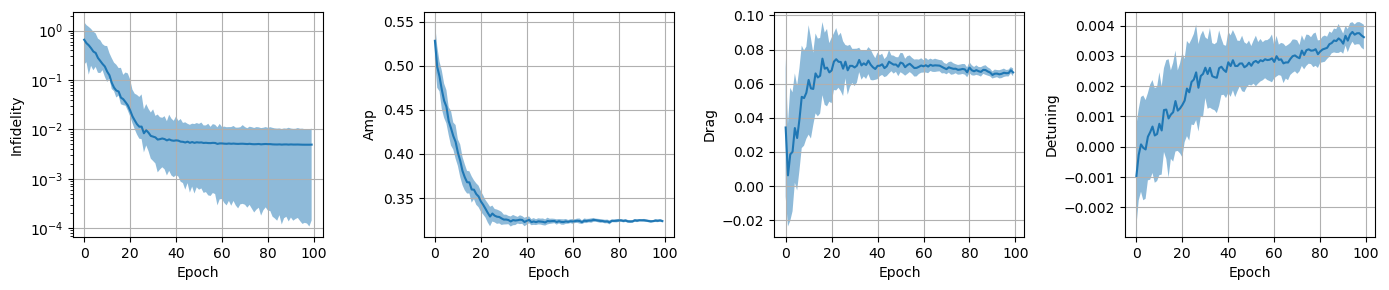

In [10]:
fig, ax = plt.subplots(1, 4, figsize=(14, 3))

ax[0].plot(epochs, mean_infidelity)
ax[0].fill_between(epochs, mean_infidelity-min_infidelity, mean_infidelity+max_infidelity, alpha = 0.5)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Infidelity')
ax[0].set_yscale('log')
ax[0].grid(True)

ax[1].plot(epochs, mean_amp)
ax[1].fill_between(epochs, mean_amp-stdev_amp, mean_amp+stdev_amp, alpha = 0.5)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Amp')
ax[1].grid(True)

ax[2].plot(epochs, mean_drag)
ax[2].fill_between(epochs, mean_drag-stdev_drag, mean_drag+stdev_drag, alpha = 0.5)
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Drag') 
ax[2].grid(True)

ax[3].plot(epochs, mean_detuning)
ax[3].fill_between(epochs, mean_detuning-stdev_detuning, mean_detuning+stdev_detuning, alpha = 0.5)
ax[3].set_xlabel('Epoch')
ax[3].set_ylabel('Detuning')
ax[3].grid(True)

fig.tight_layout()
plt.show()